In [1]:
import sys
sys.path.insert(0, "../kitti/")
from util import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D, P2, P2_tf, set_bev_background
from util import AVG_HEIGT, AVG_WIDTH, AVG_LENTH, init_zy_plt, init_xz_plt
from util import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, init_img_plt, load_tf_image
from util import draw_corner_2D, draw_birdeyes, calc_iou, draw_2Dbox, KITTI_Object, gac_original_anchor_parser
from anchor_assignment_method import maxIoU

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2

import glob
from collections import defaultdict

LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
ANCHOR_GENERATION_METHOD = "anchor_gac" # 'anchors_adaptive_Yoffset' 'anchor_gac', 'anchor_adaptive', 'anchor_dense', 'BEV_anchor'
ANCHOR_ASSIGNMENT_METHOD = "maxIoU" # "maxIoU", "L1distance", "3Ddistance"
SHOW_IMAGE = ['000169', '000173', '000185', '000296', '000369']

if ANCHOR_GENERATION_METHOD == "anchor_gac":
    # Load GAC's anchor
    anchor_2D, anchor_3D, anchor_mask, anchors = gac_original_anchor_parser("/home/lab530/KenYu/visualDet3D/anchor/max_occlusion_2_anchor.pkl", is_transform = True)
    
    # Convert to anchors_tensor
    anchors_tensor = []
    for a in anchors:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha, a.x3d, a.y3d, a.z3d, a.rot_y])
    anchors_tensor = torch.FloatTensor(anchors_tensor)

elif ANCHOR_GENERATION_METHOD == "anchor_adaptive":
    # Load adaptive anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_adaptive.pkl", 'rb') as f:
        anchors_tensor = pickle.load(f)
    
    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, is_transform = True) )

elif ANCHOR_GENERATION_METHOD == "anchors_adaptive_Yoffset":
    # Load adaptive anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_adaptive_Yoffset.pkl", 'rb') as f:
        anchors_tensor = pickle.load(f)
    
    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, is_transform = True) )

elif ANCHOR_GENERATION_METHOD == "anchor_dense":
    # Load dense anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_bev_dense.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
    # print(f"anchors_tensor = {anchors_tensor.shape}") # torch.Size([28800, 16])

    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, is_transform = True) )

elif  ANCHOR_GENERATION_METHOD == "BEV_anchor":
    # Load dense anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/BEV_anchor.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
    # print(f"anchors_tensor = {anchors_tensor.shape}") # torch.Size([28800, 16])

    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, is_transform = True) )

# Load ALL labels
labels_all = []
label_dict = defaultdict(list) # {'000169': [1,3,6,8], ...}
c = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    for label in kitti_label_file_parser(fn, is_transform = True):
        # filter labal via gac_original's critiria
        if label.occluded >= 2 or label.z3d <= 3 or label.category != "Car":
            continue
        else:
            label_dict[label.idx_img].append(c)
            labels_all.append(label)
            c += 1

print(f"Number of total ground trues = {len(labels_all)}")
# print(f"Number of total label file = {len(label_dict)}") # 
print("=====================================")

# Load images
imgs_tf = []
for img_id in SHOW_IMAGE:
    img = load_tf_image(f"/home/lab530/KenYu/kitti/training/image_2/{img_id}.png")
    imgs_tf.append(img)


Useful anchor = 18974 / 46080 
Number of total ground trues = 21291


# Draw Anchor Assignment result 

Total number of Assignment = 1005712
Total GroundTrue = 21291
Total covered groundtrue = 18647
Total missed groundtrue = 2644
Average anchors for every groundtrue = 47.23648489972289
Average cx distance = 30.84599377420342
Average cy distance = 14.1460026173073
Average x3d distance = 0.9477816982083446
Average y3d distance = 0.2601828709277369
Average z3d distance = 2.3521679808858007
Cover rate = 87.58160725189047%


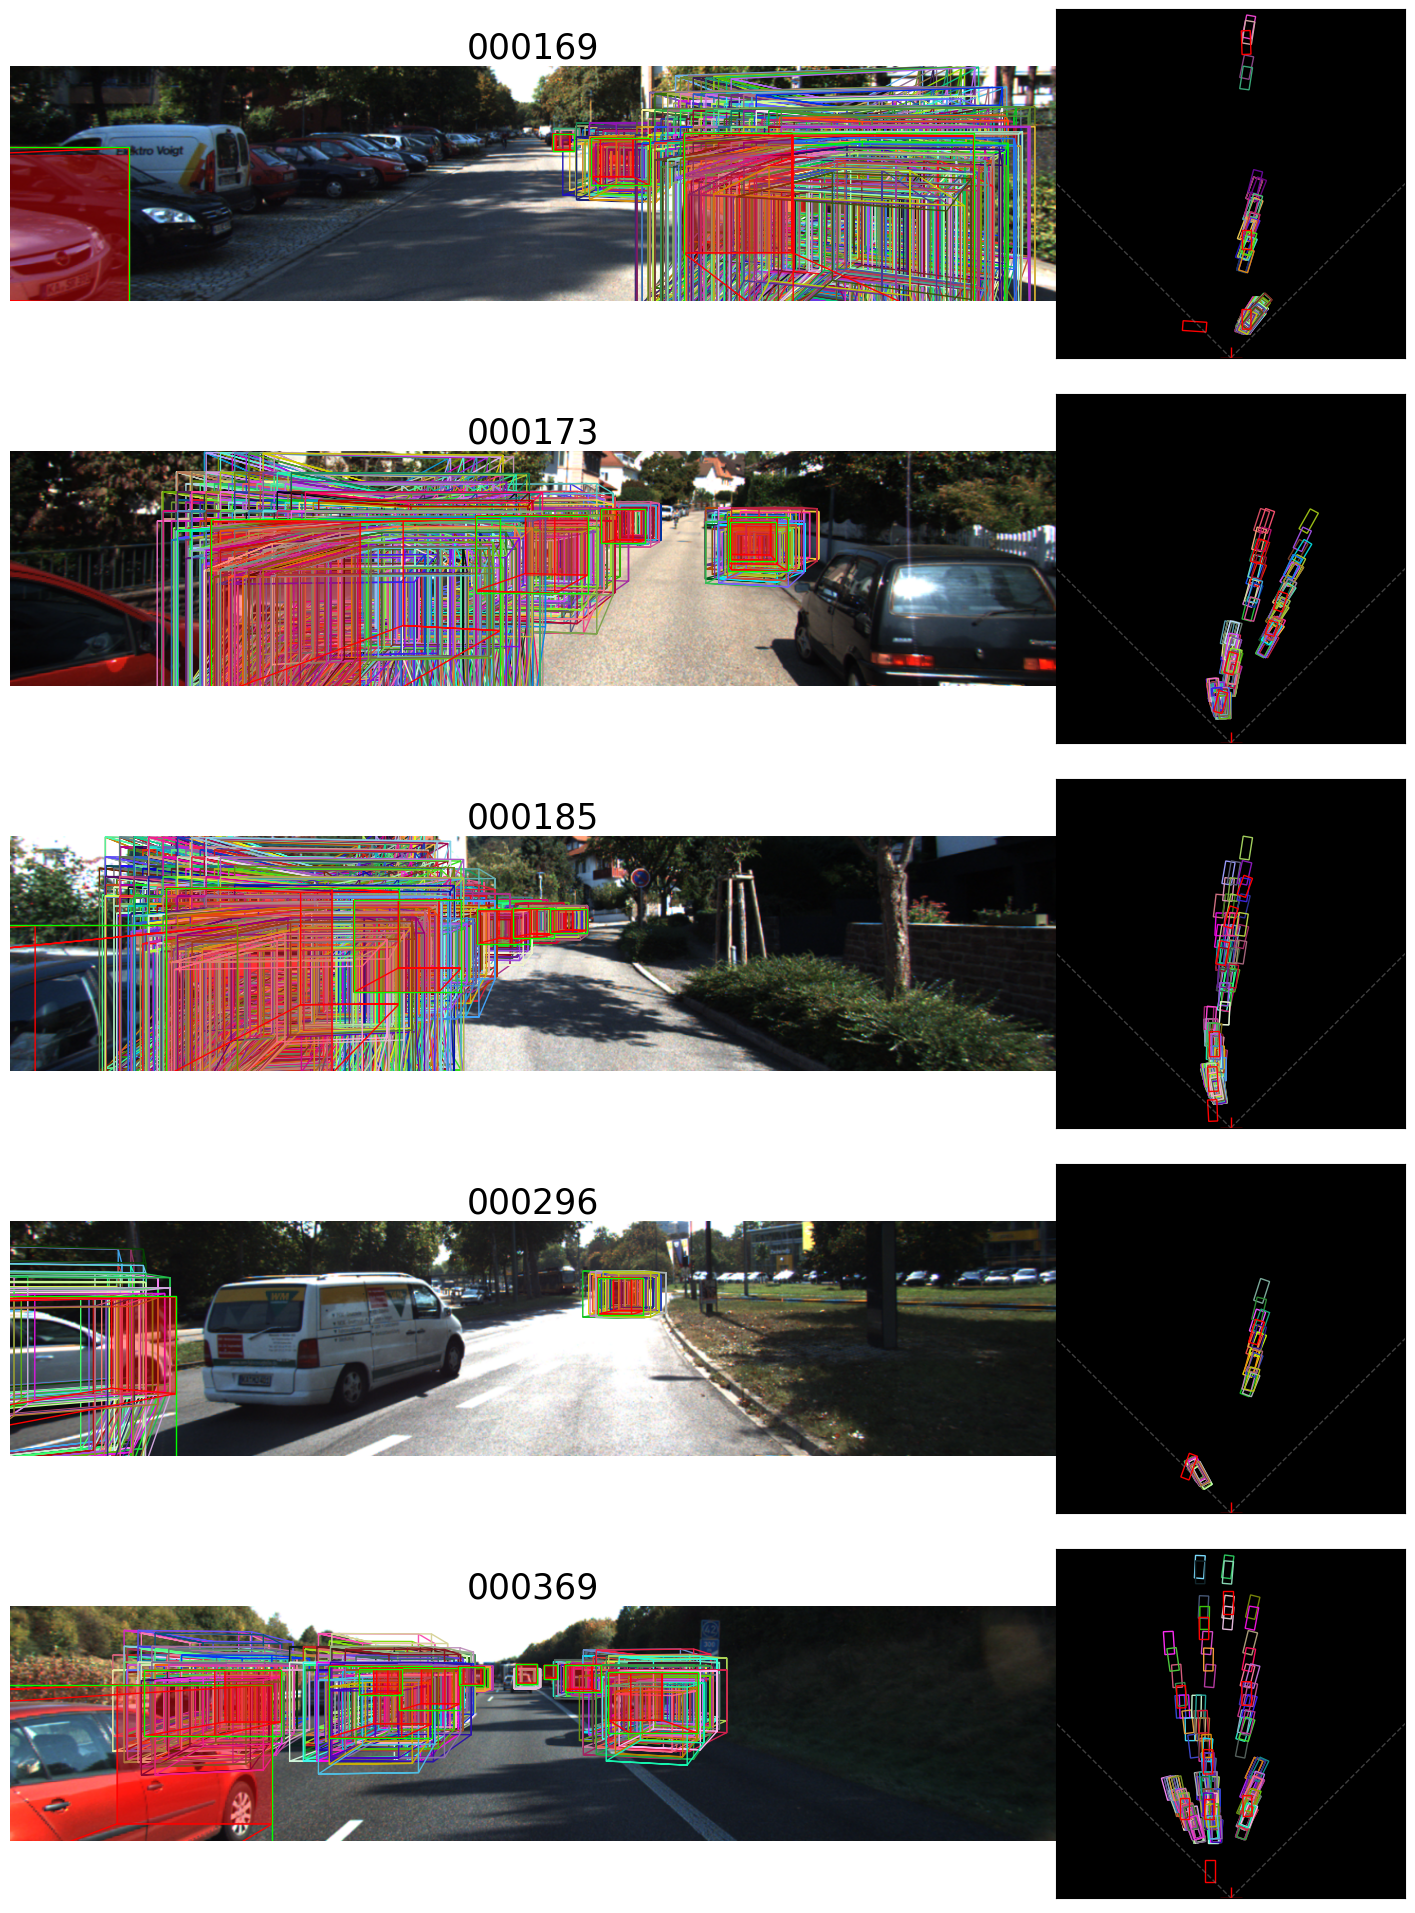

In [2]:
axs = init_img_plt(imgs_tf, SHOW_IMAGE)

assign_result = [[] for _ in range(len(labels_all))]

for idx_img in label_dict:
    # # TODO 
    # if idx_img != '000169': continue

    labels = [ labels_all[i] for i in label_dict[idx_img] ]
    if ANCHOR_ASSIGNMENT_METHOD == 'maxIoU':
        # Get labels_tensor for maxIoU
        labels_tensor = []
        for label in labels:
            labels_tensor.append([label.xmin, label.ymin, label.xmax, label.ymax])
        labels_tensor = torch.FloatTensor(labels_tensor)
        
        # Calculate maxIoU
        pos_inds, neg_inds, anchor_assignment = maxIoU(anchors_tensor, labels_tensor)

    elif ANCHOR_ASSIGNMENT_METHOD == '3Ddistance':
        ##################################################
        ### Anchor assignment via Norm_1 of (x3d, z3d) ###
        ##################################################
        # TODO maybe align with bev_ank_head.py
        # this won't work for now 
        raise NotImplementedError
        for idx_lable, label in enumerate(labels):
            norm_1 = abs(anchors_tensor[:, 12] - label.x3d) + abs(anchors_tensor[:, 14] - label.z3d)
            norm_1[ torch.abs(torch.cos(anchors_tensor[:, 15] - label.rot_y)) < pi/4 ] = float('inf')
            values, indexes = torch.topk(norm_1, 4, largest=False)
            pos_inds = indexes

    elif ANCHOR_ASSIGNMENT_METHOD == 'L1distance':
        ##################################################
        ### Anchor assignment via distance of (cx cy) ####
        ##################################################
        # TODO maybe align with bev_ank_head.py
        # this won't work for now 
        raise NotImplementedError
        for idx_lable, label in enumerate(labels):
            dist = abs(anchors_tensor[:, 5] - label.cx) + abs(anchors_tensor[:, 6] - label.cy)
            dist[ torch.abs(torch.cos(anchors_tensor[:, 15] - label.rot_y)) < pi/4 ] = float('inf')
            dist[ torch.abs(anchors_tensor[:, 7] - label.cz) > 2 ] = float('inf')
            pos_inds = torch.nonzero(dist < 16*1.414, as_tuple=False).squeeze()

    n_pos = pos_inds.shape[0]
    # n_neg = neg_inds.shape[0]
    # print(f"n_pos = {n_pos}")

    n_gt = len(labels)
    # 
    unique, counts = torch.unique(anchor_assignment, return_counts=True)
    anchor_assign = dict(zip(unique.cpu().numpy(), counts.cpu().numpy())) # {0.0: 9308, 1.0: 24}
    
    for i in range(n_gt):
        if i in anchor_assign:
            # TODO don't know why 
            assign_list = (anchor_assignment == i).nonzero(as_tuple=True)[0].numpy().tolist()
            assign_result[ label_dict[idx_img][i] ] = assign_list
            # print(f"assign_list in assignemnt = {assign_list}")

    if idx_img in SHOW_IMAGE:
        # Draw Positive anchors
        idx_show = SHOW_IMAGE.index(idx_img)
        for i in range(n_pos):
            color = (random.random(), random.random(), random.random())
            draw_corner_2D(axs[idx_show][0], anchors[pos_inds[i]].corner_2D, color = color, is_draw_front = False)
            # draw_2Dbox(axs[idx_show][0], (anchors[pos_inds[i]].xmin, anchors[pos_inds[i]].ymin, anchors[pos_inds[i]].xmax, anchors[pos_inds[i]].ymax), color = color)
            draw_birdeyes(axs[idx_show][1], anchors[pos_inds[i]], color = color)

        # Draw ground true 3d bbox
        for label in labels:
            draw_corner_2D(axs[idx_show][0], label.corner_2D,  color = (1,0,0))
            draw_2Dbox(axs[idx_show][0], (label.xmin, label.ymin, label.xmax, label.ymax), color = (0,1,0))
            draw_birdeyes(axs[idx_show][1], label, color = (1,0,0))

# Get number of covered groundTrue
n_cover_gt = 0
for assign_list in assign_result:
    if len(assign_list) > 0:
        n_cover_gt += 1

# Get number of assignment
n_assign = 0
for assign_list in assign_result:
    n_assign += len(assign_list)

# Get average L1 distance
avg_cx_dist = 0
avg_cy_dist = 0
avg_x3d_dist = 0
avg_y3d_dist = 0
avg_z3d_dist = 0
for idx_label, assign_list in enumerate(assign_result):
    for idx_anchor in assign_list:
        avg_cx_dist += abs(anchors[idx_anchor].cx - labels_all[idx_label].cx) / n_assign
        avg_cy_dist += abs(anchors[idx_anchor].cy - labels_all[idx_label].cy) / n_assign
        avg_x3d_dist += abs(anchors[idx_anchor].x3d - labels_all[idx_label].x3d) / n_assign
        avg_y3d_dist += abs(anchors[idx_anchor].y3d - labels_all[idx_label].y3d) / n_assign
        avg_z3d_dist += abs(anchors[idx_anchor].z3d - labels_all[idx_label].z3d) / n_assign

print(f"Total number of Assignment = {n_assign}")
print(f"Total GroundTrue = {len(labels_all)}")
print(f"Total covered groundtrue = {n_cover_gt}")
print(f"Total missed groundtrue = {len(labels_all) - n_cover_gt}")
print(f"Average anchors for every groundtrue = {n_assign / len(labels_all)}")
print(f"Average cx distance = {avg_cx_dist}")
print(f"Average cy distance = {avg_cy_dist}")
print(f"Average x3d distance = {avg_x3d_dist}")
print(f"Average y3d distance = {avg_y3d_dist}")
print(f"Average z3d distance = {avg_z3d_dist}")
print(f"Cover rate = {100*n_cover_gt / len(labels_all)}%")


# Analyse anchor assignment on ZY plane

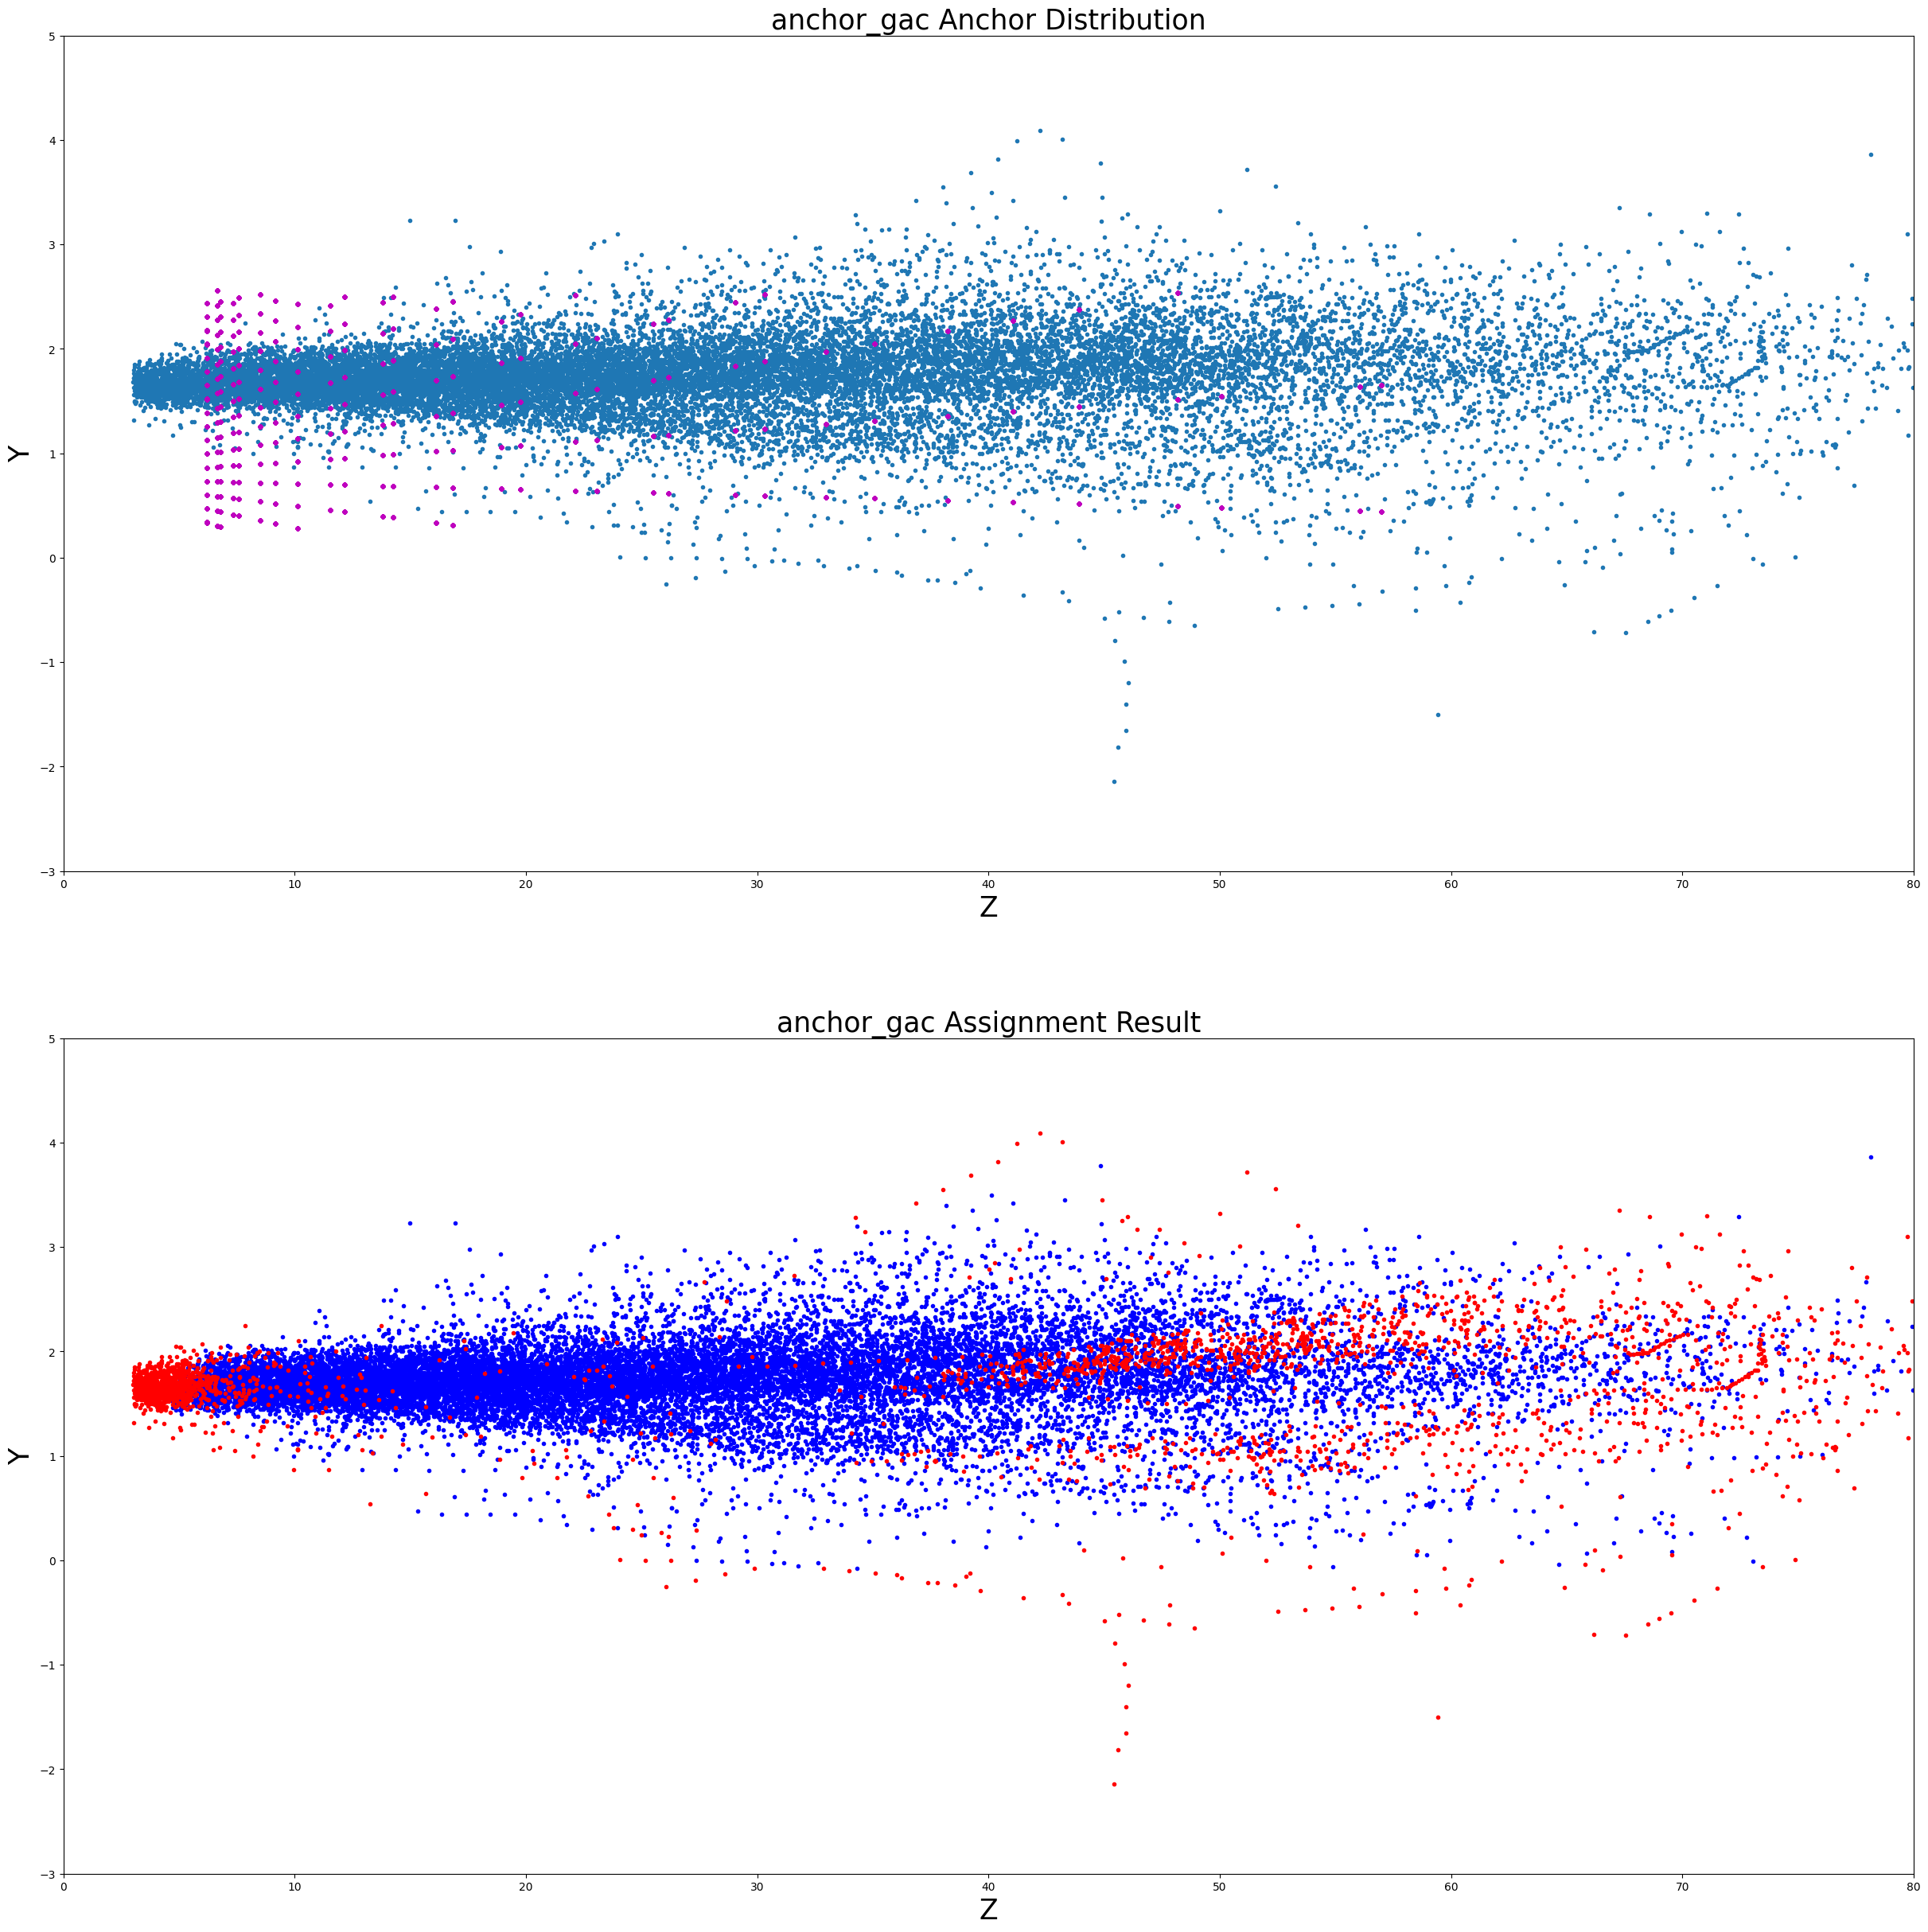

In [3]:
axs = init_zy_plt([f"{ANCHOR_GENERATION_METHOD} Anchor Distribution", f"{ANCHOR_GENERATION_METHOD} Assignment Result"])

# Draw Ground true
axs[0].plot([l.z3d for l in labels_all], [l.y3d for l in labels_all], '.') # Draw ground true

# Draw anchors
axs[0].plot([a.z3d for a in anchors], [a.y3d for a in anchors], '.m',) # Draw filtered GAC anchor

covered_gt_list = []
missed_gt_list = []
for i, assign_list in enumerate(assign_result):
    if len(assign_list) > 0: # Covered gt
        covered_gt_list.append(i)
    else:
        missed_gt_list.append(i)

# Draw Assignemnt result
axs[1].plot([labels_all[i].z3d for i in covered_gt_list], [labels_all[i].y3d for i in covered_gt_list], '.b',)
axs[1].plot([labels_all[i].z3d for i in missed_gt_list], [labels_all[i].y3d for i in missed_gt_list], '.r',)



# Anchor Assignment on XZ plane

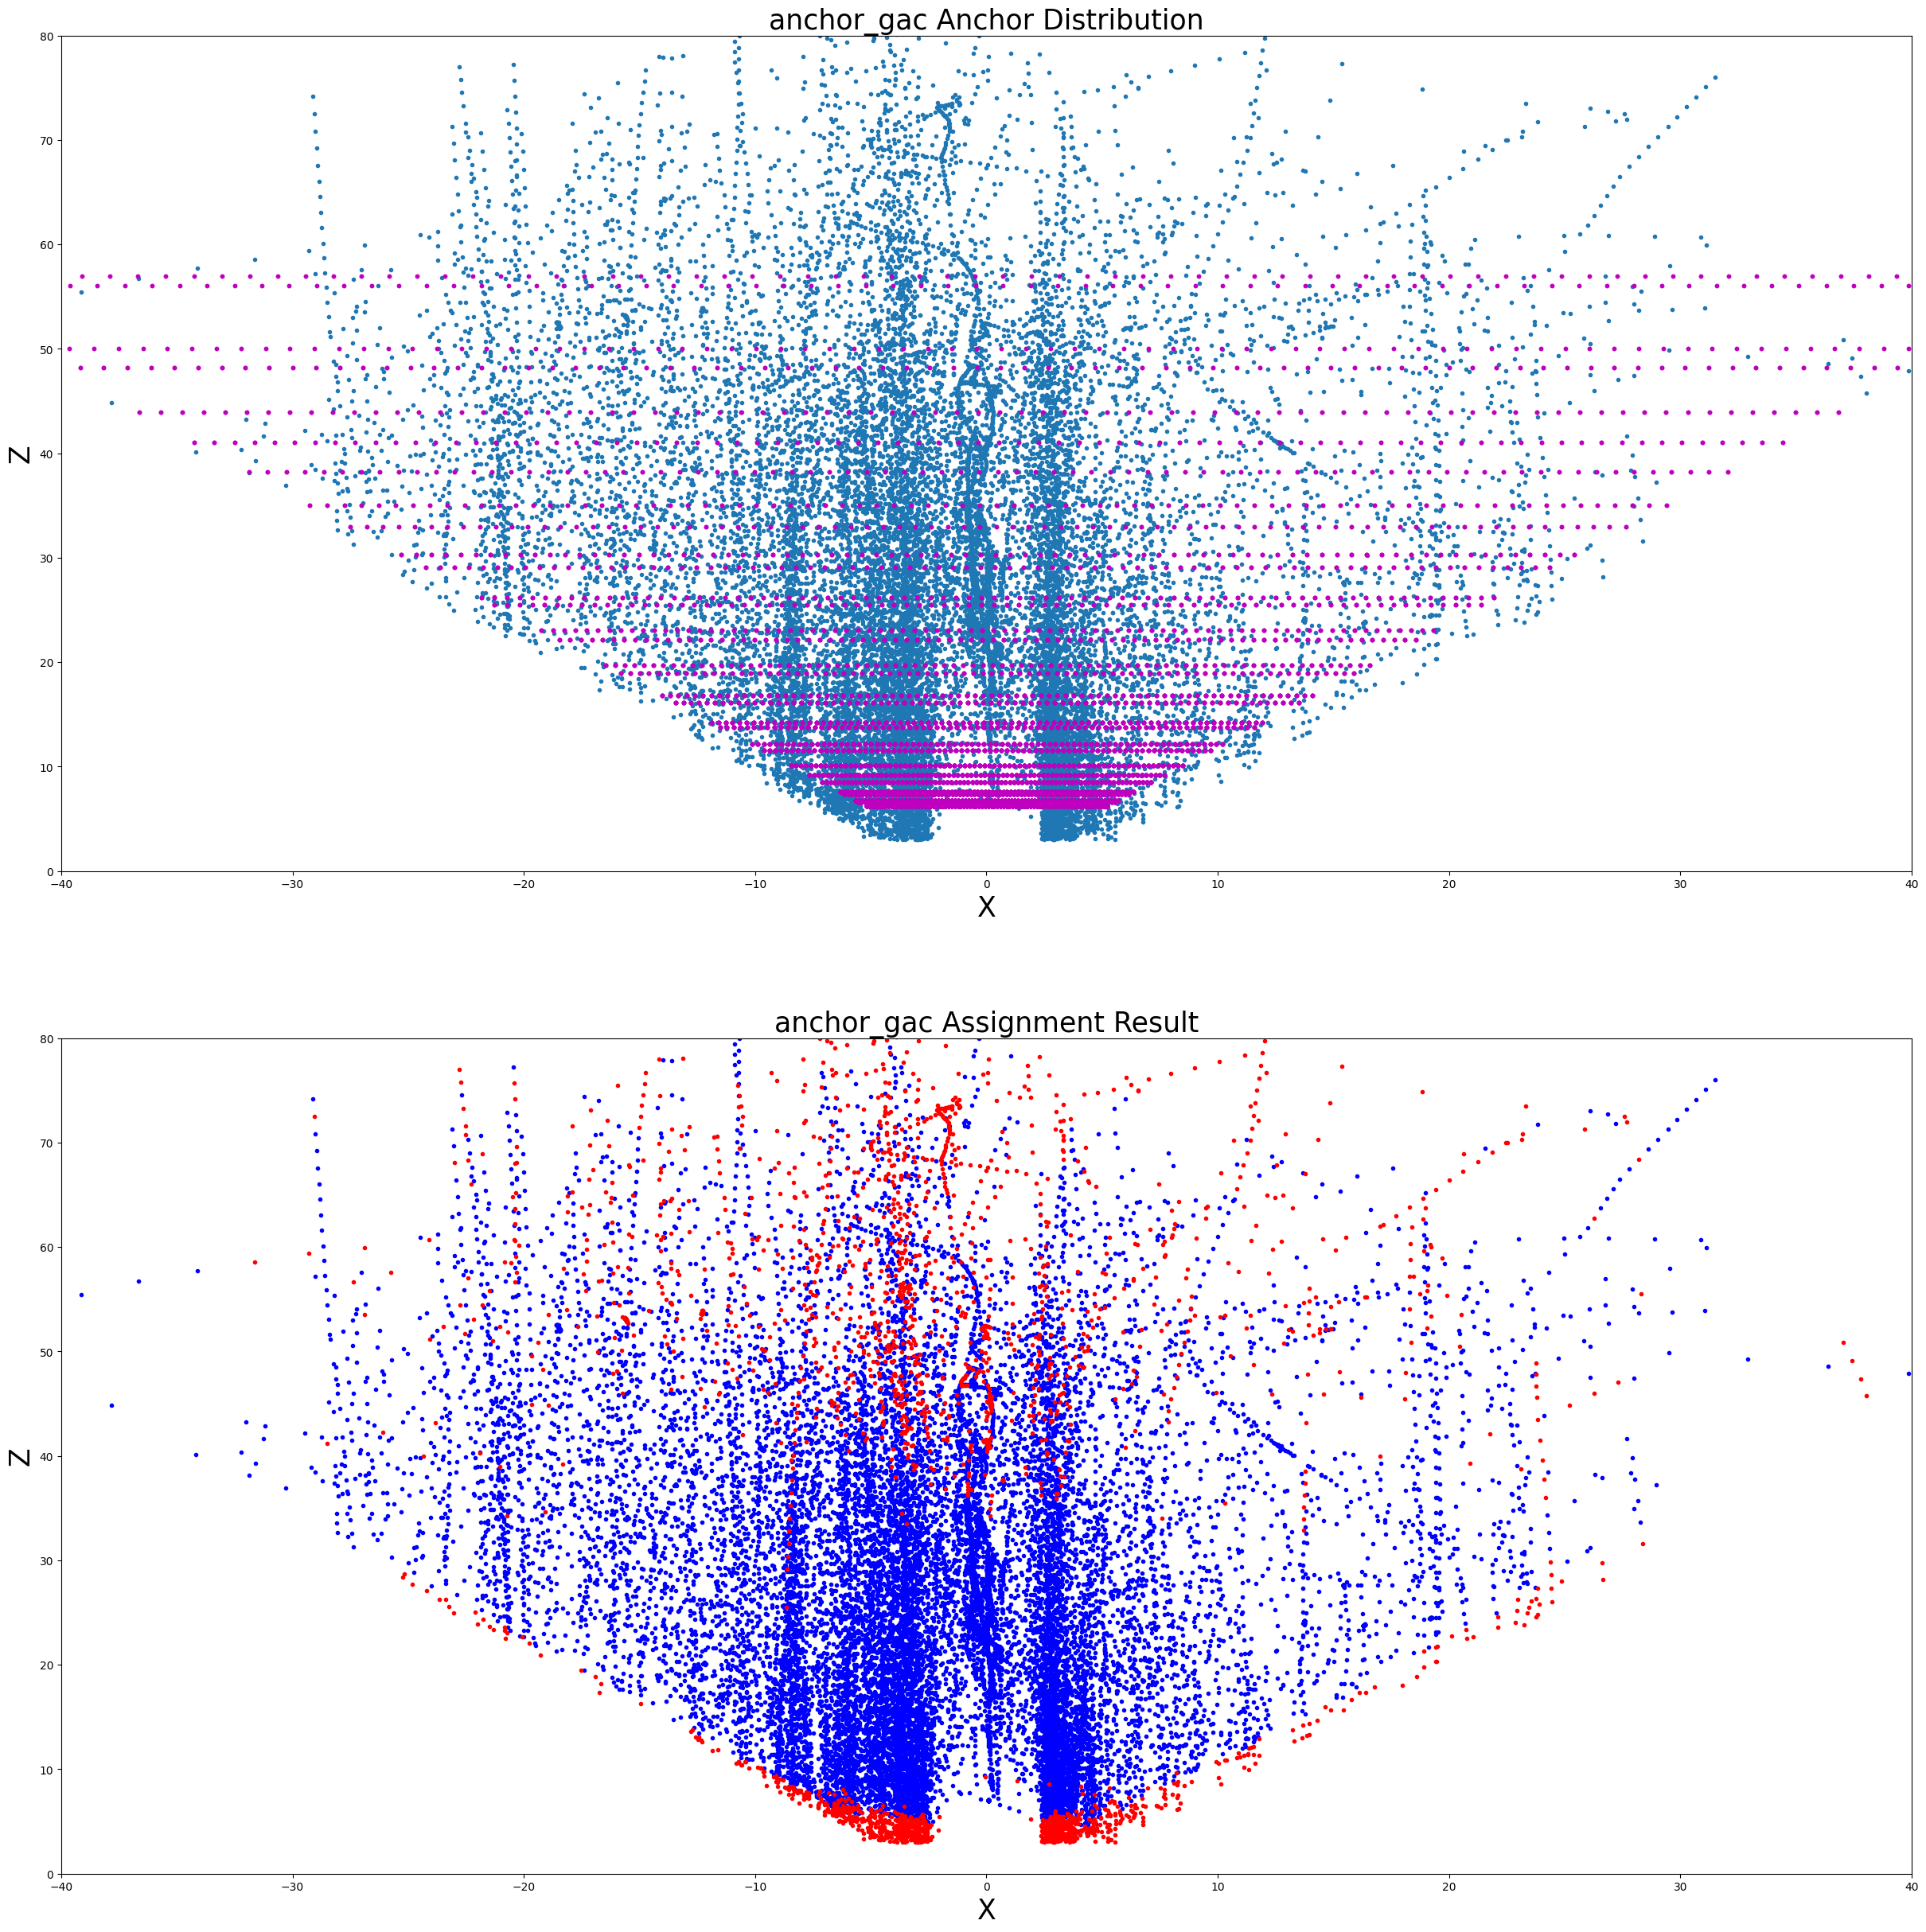

In [4]:
axs = init_xz_plt([f"{ANCHOR_GENERATION_METHOD} Anchor Distribution", f"{ANCHOR_GENERATION_METHOD} Assignment Result"])

# Draw Ground true
axs[0].plot([l.x3d for l in labels_all], [l.z3d for l in labels_all], '.') # Draw ground true

# Draw anchors
axs[0].plot([a.x3d for a in anchors], [a.z3d for a in anchors], '.m',) # Draw filtered GAC anchor

covered_gt_list = []
missed_gt_list = []
for i, assign_list in enumerate(assign_result):
    if len(assign_list) > 0: # Covered gt
        covered_gt_list.append(i)
    else:
        missed_gt_list.append(i)

# Draw Assignemnt result
axs[1].plot([labels_all[i].x3d for i in covered_gt_list], [labels_all[i].z3d for i in covered_gt_list], '.b',)
axs[1].plot([labels_all[i].x3d for i in missed_gt_list], [labels_all[i].z3d for i in missed_gt_list], '.r',)

